In [3]:
# !pip install vincenty

In [4]:
# import data analysis libraries
import pandas as pd
import numpy as np

# other
import os
import warnings

# visualisation libraries
from matplotlib import pyplot as plt
import seaborn as sns

from vincenty import vincenty
from glob import glob

# Notebook styling
%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
warnings.filterwarnings("ignore")

In [5]:
def add_feat(df_input):
    """
    This function takes in raw lat long time series from the microsoft geolife data.
    
    Preprocessing notes: skip the first six lines before doing pandas read csv ,
    expecting columns in ['lat','long', 'null', 'alt' ,'DateTime','Date','Time']
    
    Requres: pandas imported as pd
             from vincenty import vincenty
         
    Adds:
        speed
        acceleration
        jerk
        bearing rate
        distance travelled
    """
    
    df = df_input
    
    # add some initial shifts
    df['lat_shift'] = df.lat.shift(-1)
    df['long_shift'] = df.long.shift(-1)
    df['time_shift'] = df.DateTime.shift(-1)
    
    # add speed
    def speed(x):
        try:
            s = vincenty((x[-3],x[-2]),(x[0],x[1]), miles = True) / ((x[-1]-x[4]) * 24)
        except:
            s= np.nan
        return s
    
    df['speed_mph'] = df.apply(speed,axis =1)
    df['speed_shift'] = df.speed_mph.shift(-1)
    
    # add acceleration
    def accel(x):
        try:
            a = (x[-1] - x[-2]) / ((x[9] - x[4]) *24*60*60)
        except:
            a = np.nan
        return a
    
    df['acceleration'] = df.apply(accel, axis =1)
    df['acceleration_shift'] = df.acceleration.shift(-1)
    
    # add jerk
    def jerk(x):
        try:
            j = (x[-1] - x[-2]) / ((x[9] - x[4]) *24*60*60)
        except:
            j = np.nan
        return a
    
    df['jerk'] = df.apply(accel, axis =1)
    df['jerk_shift'] = df.jerk.shift(-1)
    
    # add y for bearing calculator
    def y(x):
        try:
            yy = np.sin((x[8] - x[0]) * np.pi/180) *np.cos( x[7]* np.pi/180)
        except:
            yy= np.nan
        return yy
    
    df['y'] = df.apply(y, axis =1)
    
    # add x for bearing calculator 
    def x(x):
        try:
            xx = np.cos(x[0] * np.pi/180) *np.sin(x[7]* np.pi/180) - np.sin(x[0]* np.pi/180) * np.cos(x[7]* np.pi/180)*np.cos((x[8]-x[1])* np.pi/180)
        except:
            xx = np.nan
        return xx
    
    df['x'] = df.apply(x,axis =1)
    
    # calculate bearing
    def bearing(x):
        try:
            b = np.arctan2(x[-2],x[-1])*180/np.pi
        except:
            b = np.nan
        return b
    
    df['bearing'] = df.apply(bearing,axis=1)
    df['brearing_shift'] = df.bearing.shift(-1)
    
    # calculate bearing rate (rate of change of direction)
    def bearing_rate(x):
        try:
            br = abs(x[-1]-x[-2])
        except:
            br = np.nan
        return br
    
    df['bearing_rate'] = df.apply(bearing_rate,axis=1)
    
    # calculate distance travelled
    def distance(x):
        try:
            dist = vincenty((x[7],x[8]),(x[0],x[1]), miles = True)
        except:
            dist= np.nan
        return dist
    
    df['distance'] = df.apply(distance,axis = 1)
    
    df.drop(df.tail(4).index,inplace=True)
    
    return df

def list_df_summary(input_df):
    '''
    Converts output from add_feat function into an observation for machine learning
    '''
    names = ['speed_10','speed_25','speed_50','speed_75','speed_90','speed_ave',
            'accel_10','accel_25','accel_50','accel_75','accel_90','accel_ave',
            'jerk_10','jerk_25','jerk_50','jerk_75','jerk_90','jerk_ave',
            'bearingRate_10','bearingRate_25','bearingRate_50','bearingRate_75','bearingRate_90','bearingRate_ave',
            'distance_traveled','time_traveled' ,'last_lat','last_long','start_lat','start_long'
            
            ]
    values = list()
    
    #speed
    values.append(input_df.quantile(.10)[8])
    values.append(input_df.quantile(.25)[8])
    values.append(input_df.quantile(.50)[8])
    values.append(input_df.quantile(.75)[8])
    values.append(input_df.quantile(.90)[8])
    values.append(input_df.mean()[8])
    
    #accel
    values.append(input_df.quantile(.10)[10])
    values.append(input_df.quantile(.25)[10])
    values.append(input_df.quantile(.50)[10])
    values.append(input_df.quantile(.75)[10])
    values.append(input_df.quantile(.90)[10])
    values.append(input_df.mean()[10])
    
    #jerk
    values.append(input_df.quantile(.10)[12])
    values.append(input_df.quantile(.25)[12])
    values.append(input_df.quantile(.50)[12])
    values.append(input_df.quantile(.75)[12])
    values.append(input_df.quantile(.90)[12])
    values.append(input_df.mean()[12])
    
    #bearing
    values.append(input_df.quantile(.10)[18])
    values.append(input_df.quantile(.25)[18])
    values.append(input_df.quantile(.50)[18])
    values.append(input_df.quantile(.75)[18])
    values.append(input_df.quantile(.90)[18])
    values.append(input_df.mean()[18])
    
    #distance travelled
    values.append(input_df.distance.sum())
    
    #time travelled
    values.append((input_df.iloc[-1,4] - input_df.iloc[0,4])*24*60)
    
    #lat long
    values.append(input_df.iloc[-1,0])
    values.append(input_df.iloc[-1,1])
    values.append(input_df.iloc[0,0])
    values.append(input_df.iloc[0,1])
    
    
    return pd.DataFrame([values],columns=names)

# Initial Data Assessment

## Import Data

In [7]:
# define col names
colnames = ['lat','long', 'null', 'alt' ,'DateTime','Date','Time']
file_loc = '../../data/Raw/Geolife Trajectories 1.3/Data/010/Trajectory/20081207101046.plt'

df_dataset = pd.read_csv(file_loc, skiprows=6, names = colnames)
print(df_dataset.shape)
df_dataset.head()

(3696, 7)


lat        long  null  alt      DateTime        Date      Time
0  39.137358  117.212149     0  112  39789.424144  2008-12-07  10:10:46
1  39.137353  117.212146     0  112  39789.424155  2008-12-07  10:10:47
2  39.137346  117.212143     0  112  39789.424167  2008-12-07  10:10:48
3  39.137338  117.212140     0  115  39789.424178  2008-12-07  10:10:49
4  39.137331  117.212136     0  115  39789.424190  2008-12-07  10:10:50

In [8]:
df_dataset.tail()

lat        long  null  alt      DateTime        Date      Time
3691  39.991644  116.326376     0  184  39789.525972  2008-12-07  12:37:24
3692  39.991641  116.326325     0  180  39789.525984  2008-12-07  12:37:25
3693  39.991641  116.326289     0  177  39789.525995  2008-12-07  12:37:26
3694  39.991643  116.326273     0  174  39789.526007  2008-12-07  12:37:27
3695  39.991644  116.326263     0  167  39789.526019  2008-12-07  12:37:28

In [44]:
df_dataset['Time'] = pd.to_datetime(df_dataset['Time'],format= '%H:%M:%S')
df_dataset['Time'].head()

In [45]:
df_dataset.sort_values('Time', inplace=True)

In [46]:
# plot 
df_dataset['Time']

0      1900-01-01 10:10:46
1      1900-01-01 10:10:47
2      1900-01-01 10:10:48
3      1900-01-01 10:10:49
4      1900-01-01 10:10:50
               ...        
3687   1900-01-01 12:37:19
3688   1900-01-01 12:37:20
3689   1900-01-01 12:37:21
3690   1900-01-01 12:37:22
3691   1900-01-01 12:37:24
Name: Time, Length: 3692, dtype: datetime64[ns]

In [47]:
# plot 
df_dataset['Time'].diff().cumsum()

0                                   NaT
1      -106752 days +00:12:44.145224192
2      -106752 days +00:12:45.145224192
3      -106752 days +00:12:46.145224192
4      -106752 days +00:12:47.145224192
                     ...               
3687   -106752 days +02:39:16.145224192
3688   -106752 days +02:39:17.145224192
3689   -106752 days +02:39:18.145224192
3690   -106752 days +02:39:19.145224192
3691   -106752 days +02:39:21.145224192
Name: Time, Length: 3692, dtype: timedelta64[ns]

In [72]:
# plot 
df_dataset['Time'].diff()

0                  NaT
1      0 days 00:00:01
2      0 days 00:00:01
3      0 days 00:00:01
4      0 days 00:00:01
             ...      
3687   0 days 00:00:01
3688   0 days 00:00:01
3689   0 days 00:00:01
3690   0 days 00:00:01
3691   0 days 00:00:02
Name: Time, Length: 3692, dtype: timedelta64[ns]

In [75]:
# plot 
df_dataset['Time_elapsed_seconds'] = df_dataset['Time'].diff().dt.seconds
df_dataset['Time_elapsed_seconds']

0       NaN
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3687    1.0
3688    1.0
3689    1.0
3690    1.0
3691    2.0
Name: Time_elapsed_seconds, Length: 3692, dtype: float64

In [65]:
# plot 
time_diff_frequency = df_dataset['Time'].diff().dt.seconds.value_counts()
time_diff_frequency

1.0       3254
2.0        417
3.0          4
8.0          1
60.0         1
22.0         1
6.0          1
58.0         1
4.0          1
540.0        1
1069.0       1
56.0         1
92.0         1
1547.0       1
203.0        1
830.0        1
102.0        1
74.0         1
27.0         1
Name: Time, dtype: int64

In [69]:
time_diff_frequency.index

Float64Index([   1.0,    2.0,    3.0,    8.0,   60.0,   22.0,    6.0,   58.0,
                 4.0,  540.0, 1069.0,   56.0,   92.0, 1547.0,  203.0,  830.0,
               102.0,   74.0,   27.0],
             dtype='float64')

In [71]:
stops = [i for i in time_diff_frequency.index
        if i >= 420]
print(stops)
time_diff_frequency.loc[stops]

[540.0, 1069.0, 1547.0, 830.0]


540.0     1
1069.0    1
1547.0    1
830.0     1
Name: Time, dtype: int64

In [35]:
df_dataset['Time'].apply(lambda x: int(x[-2:])).diff().value_counts()

 1.0     3188
 2.0      416
-59.0      66
 3.0        3
 0.0        2
-13.0       1
-18.0       1
 23.0       1
 22.0       1
-54.0       1
-2.0        1
-57.0       1
-10.0       1
 4.0        1
 8.0        1
 27.0       1
-58.0       1
-4.0        1
 14.0       1
-28.0       1
-11.0       1
Name: Time, dtype: int64

In [32]:
# plot 
df_dataset['Time'].apply(lambda x: int(x[-2:])).diff().cumsum()

0        NaN
1        1.0
2        2.0
3        3.0
4        4.0
        ... 
3687   -27.0
3688   -26.0
3689   -25.0
3690   -24.0
3691   -22.0
Name: Time, Length: 3692, dtype: float64

# Data Preparation

In [11]:
df_dataset = add_feat(df_dataset)
print(df_dataset.shape)
df_dataset.head()

(3692, 22)


lat        long  null  alt      DateTime        Date      Time  \
0  39.137358  117.212149     0  112  39789.424144  2008-12-07  10:10:46   
1  39.137353  117.212146     0  112  39789.424155  2008-12-07  10:10:47   
2  39.137346  117.212143     0  112  39789.424167  2008-12-07  10:10:48   
3  39.137338  117.212140     0  115  39789.424178  2008-12-07  10:10:49   
4  39.137331  117.212136     0  115  39789.424190  2008-12-07  10:10:50   

   lat_shift  long_shift    time_shift  ...  acceleration  acceleration_shift  \
0  39.137353  117.212146  39789.424155  ...      0.460796            0.237618   
1  39.137346  117.212143  39789.424167  ...      0.237618           -0.165620   
2  39.137338  117.212140  39789.424178  ...     -0.165620            0.349199   
3  39.137331  117.212136  39789.424190  ...      0.349199           -0.554398   
4  39.137328  117.212125  39789.424201  ...     -0.554398            0.090007   

       jerk  jerk_shift         y             x    bearing  brearing_shift  \
0 -0.223178   -0.403237  0.758895 -8.726646e-08  90.000007       90.000009   
1 -0.403237    0.514823  0.758896 -1.221730e-07  90.000009       90.000011   
2  0.514823   -0.903595  0.758896 -1.396263e-07  90.000011       90.000009   
3 -0.903595    0.644404  0.758896 -1.221730e-07  90.000009       90.000004   
4  0.644404   -0.408611  0.758896 -5.235987e-08  90.000004       90.000007   

   bearing_rate  distance  
0      0.000003  0.000381  
1      0.000001  0.000509  
2      0.000001  0.000575  
3      0.000005  0.000529  
4      0.000003  0.000626  

[5 rows x 22 columns]

In [25]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3692 entries, 0 to 3691
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lat                 3692 non-null   float64
 1   long                3692 non-null   float64
 2   null                3692 non-null   int64  
 3   alt                 3692 non-null   int64  
 4   DateTime            3692 non-null   float64
 5   Date                3692 non-null   object 
 6   Time                3692 non-null   object 
 7   lat_shift           3692 non-null   float64
 8   long_shift          3692 non-null   float64
 9   time_shift          3692 non-null   float64
 10  speed_mph           3692 non-null   float64
 11  speed_shift         3692 non-null   float64
 12  acceleration        3692 non-null   float64
 13  acceleration_shift  3692 non-null   float64
 14  jerk                3692 non-null   float64
 15  jerk_shift          3692 non-null   float64
 16  y     

In [23]:
df_dataset.columns

Index(['lat', 'long', 'null', 'alt', 'DateTime', 'Date', 'Time', 'lat_shift',
       'long_shift', 'time_shift', 'speed_mph', 'speed_shift', 'acceleration',
       'acceleration_shift', 'jerk', 'jerk_shift', 'y', 'x', 'bearing',
       'brearing_shift', 'bearing_rate', 'distance'],
      dtype='object')

In [24]:
df_dataset['speed_mph'].plot(kind='line')

<AxesSubplot:>

<AxesSubplot:>

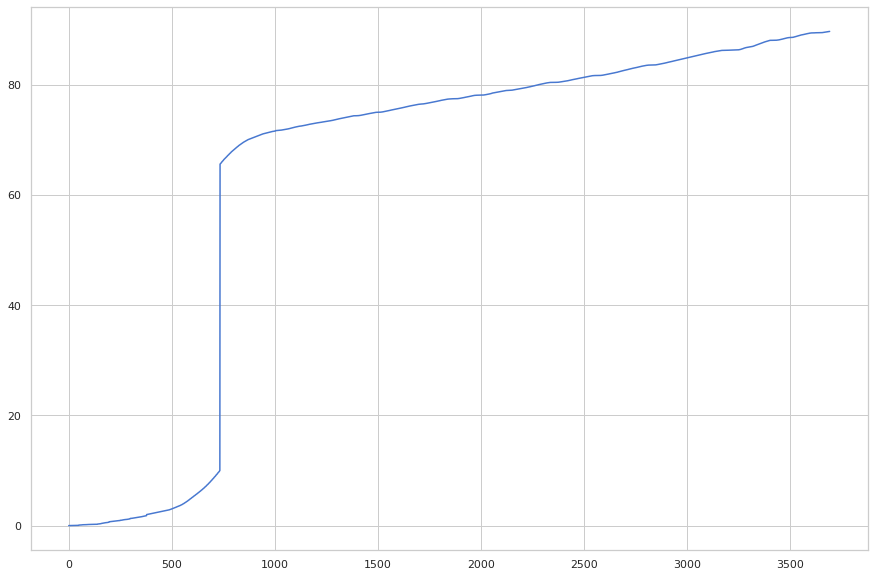

In [27]:
df_dataset['distance'].cumsum().plot(kind='line')

## Separate Legs

In [28]:
df_dataset['cumm_distance'] = df_dataset['distance'].cumsum()
df_dataset['cumm_distance'].head()

0    0.000381
1    0.000890
2    0.001465
3    0.001994
4    0.002620
Name: cumm_distance, dtype: float64

In [ ]:
# define number of rows to iterate over
n_rows = 7

# define row indexes to iterate over
a = df_1.index.values[:-n_rows+1]

# iterate over rows
for i in a:
    print(df_1.iloc[i:i+n_rows], '\n')

## Engineer Features

In [7]:
df_dataset = list_df_summary(add_feat(pd.read_csv(file_loc, skiprows=6,names=colnames)))
print(df_dataset.shape)
df_dataset.head()

(1, 30)


speed_10  speed_25   speed_50   speed_75   speed_90  speed_ave  accel_10  \
0  0.626399  2.629794  15.703167  34.338506  83.687732  26.192144 -2.235824   

   accel_25  accel_50  accel_75  ...  bearingRate_50  bearingRate_75  \
0 -0.835209 -0.018249  0.752277  ...        0.000007         0.00002   

   bearingRate_90  bearingRate_ave  distance_traveled  time_traveled  \
0          0.0001         0.000682          82.557069     132.883333   

    last_lat   last_long  start_lat  start_long  
0  39.136261  117.218261    39.9921  116.331613  

[1 rows x 30 columns]

In [5]:
# plts = []
# for folder in glob('../../data/Raw/Geolife Trajectories 1.3/Data/*/Trajectory'):
#     for file in glob(folder +'/*.plt'):
#         plts.append(file)
#         large_df = []
        
# for i, file in enumerate(plts):
#     print( int(i*100 / len(plts)))
#     try:
#         large_df.append(list_df_summary(add_feat(pd.read_csv(file, skiprows=6,names=colnames))))
#     except:
#         print('error at: ' + file)
        
# df_dataset = pd.concat(large_df)
# print(df_dataset.shape)
# df_dataset.head()

In [ ]:
from sklearn.preprocessing import StandardScaler

## Remove longer trips
df_local_all_feat = df_dataset[(df_dataset.time_traveled < 300)
                               & (df_dataset.distance_traveled < 100)
                               & (df_dataset.speed_90 < 75)]

## Select Features with unique distributions
select_cols = ['speed_90','speed_ave','accel_75','speed_50','accel_ave','distance_traveled','time_traveled']
df_local = df_local_all_feat[select_cols]

## Scale Data for KMeans
X = StandardScaler()
X = X.fit_transform(df_local)

In [ ]:
from sklearn.cluster import KMeans

df_local_all_feat['cluster'] = KMeans(n_clusters=7).fit_predict(X)
print(df_local_all_feat.shape)
df_local_all_feat.head()

In [38]:
# Create Column to identify stop overs
df_dataset['trip_leg_id'] = np.nan

# instantiate variables
leg_counter = 0
previous_point = 'stop'

# for each waypoint...
for current_index in df_dataset.index:
    
    # if current row is 'stop'...
    if df_dataset.loc[current_index, 'bool_stop_over'] == True:
        
        # make current_point = 'stop'
        current_point = 'stop'
        
        # impute current point to dataframe value
        df_dataset.loc[current_index, 'trip_leg_id'] = current_point

    # ... else
    else:
        # make current_point = leg_counter
        current_point = f'leg_{leg_counter}'
        
        # if previous_point = 'stop'...
        if previous_point == 'stop':
            # add 1 to the leg counter
            leg_counter += 1
            current_point = f'leg_{leg_counter}'
            
            # impute current point to dataframe value
            df_dataset.loc[current_index, 'trip_leg_id'] = current_point
            
        # ... else
        else:
            # impute current point to dataframe value
            current_point = f'leg_{leg_counter}'
            df_dataset.loc[current_index, 'trip_leg_id'] = current_point
                
    # update previous point
    previous_point = current_point
        
print(df_dataset.shape)
df_dataset[['cumm_distance','Time_elapsed_seconds','bool_stop_over', 'trip_leg_id']].head()

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1.2
1.2.1
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1
1
1
1
1.2
1.2.1
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1.2
1.2.1
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2


1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1
1.2
1.2.1
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.

1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1.2
1.2.1
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.

1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1.2
1.2.1
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.2
1.2
1.2.

cumm_distance  Time_elapsed_seconds bool_stop_over trip_leg_id
0          0.613                   NaN           True        stop
1          1.432                   1.0           True        stop
2          2.357                   1.0           True        stop
3          3.208                   1.0           True        stop
4          4.216                   1.0           True        stop

In [17]:
# Create Column to identify stop overs
find_stops['bool_stop_over'] = np.nan

# for each row [interval upper boundary]
for upper_index in df_dataset.index:
    delta_index = 0
    time_interval = 0
    
    # get a 7 min interval
    while time_interval < 421:
        delta_index += 1
        time_interval += df_dataset['Time_elapsed_seconds'].iloc[upper_index: upper_index + delta_index].sum()
        
        df_interval = df_dataset.iloc[upper_index: upper_index + delta_index]

    # sum the distance covered in the interval
    interval_distance = df_interval['distance'].sum()
    
    # if the sum is greater than 100m, False
    if interval_distance >= 100:
        df_dataset.loc[upper_index: upper_index + delta_index, 'bool_stop_over'] = False
        
    # else, True
    else:
        df_dataset.loc[upper_index: upper_index + delta_index, 'bool_stop_over'] = True
    
print(df_dataset.shape)
df_dataset[['cumm_distance','Time_elapsed_seconds','bool_stop_over']].head()

NameError: name 'find_stops' is not defined